<a href="https://colab.research.google.com/github/SRJ-7/Speech-Recognition-Mother-Tongue-/blob/main/Marathi_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Forced Alignment with Wav2Vec2

**Author**: [Moto Hira](moto@meta.com)_

This tutorial shows how to align transcript to speech with
``torchaudio``, using CTC segmentation algorithm described in
[CTC-Segmentation of Large Corpora for German End-to-end Speech
Recognition](https://arxiv.org/abs/2007.09127)_.

<div class="alert alert-info"><h4>Note</h4><p>This tutorial was originally written to illustrate a usecase
   for Wav2Vec2 pretrained model.

   TorchAudio now has a set of APIs designed for forced alignment.
   The [CTC forced alignment API tutorial](./ctc_forced_alignment_api_tutorial.html)_ illustrates the
   usage of :py:func:`torchaudio.functional.forced_align`, which is
   the core API.

   If you are looking to align your corpus, we recommend to use
   :py:class:`torchaudio.pipelines.Wav2Vec2FABundle`, which combines
   :py:func:`~torchaudio.functional.forced_align` and other support
   functions with pre-trained model specifically trained for
   forced-alignment. Please refer to the
   [Forced alignment for multilingual data](forced_alignment_for_multilingual_data_tutorial.html)_ which
   illustrates its usage.</p></div>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install fairseq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 38.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_

In [ ]:
import torch

# Load the model
model = torch.load('/content/drive/MyDrive/SPRING_INX_wav2vec2_Marathi.pt')

# Print the model
print(model)

{'args': None, 'cfg': {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 200, 'log_format': 'json', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppress_crashes': False, 'use_plasma_view': False, 'plasma_path': '/tmp/plasma'}, 'common_eval': {'_name': None, 'path': None, 'post_p

In [ ]:
from IPython.display import Javascript

from google.colab import output
from google.colab import drive

from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment
from matplotlib import pyplot as plt
import numpy as np
import scipy.io.wavfile
import io
import os
from IPython.display import Audio

# Mount Google Drive
# drive.mount('/content/drive')

# Copy the file from Google Drive to the working directory
!cp /content/drive/MyDrive/easy_hindi1.wav .
# !cp /content/drive/MyDrive/easy_hindi1_mispronounced.wav .
# !cp /content/drive/MyDrive/easy_hindi2.wav .
# !cp /content/drive/MyDrive/mispronounced.wav .
# !cp /content/drive/MyDrive/marathi_mother.wav .
# !cp /content/drive/MyDrive/marathi_mother_fast.wav .
# !cp /content/drive/MyDrive/marathi_mother_slow.wav .
# !cp /content/drive/MyDrive/marathi_mother_0.8x.wav .
# !cp /content/drive/MyDrive/marathi_mother_0.8x.wav .

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=4):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  return audio


# Please comment below line, if you already uploaded the sound_path in '/content/'
# !rm recording.wav
#### You can run this module in the loop to record more repetitions of the digits.
# sound_path = "easy_hindi1_mispronounced.wav"
# sound_path = "mispronounced.wav"
sound_path = "easy_hindi1.wav"
# sound_path = "easy_hindi2.wav"
# sound_path = "marathi_mother.wav"
# sound_path = "marathi_mother_fast.wav"
# sound_path = "marathi_mother_0.8x.wav"
# sound_path = "marathi_mother_slow.wav"

# sound_path = "recording.wav"
if os.path.isfile(sound_path):
    print("wavefile exists, later part of the code uses sound_path as input speech")
    wav = AudioSegment.from_wav(sound_path)
else:
    print("Recording the digits")
    wav = record(4.0) #It will record three seconds of your speech. You can change the duration.
    wav = wav.set_frame_rate(16000)
    sig=wav.get_array_of_samples()
    samples=np.array(sig).T.astype(np.float32)
    fp_arr = np.array(samples).T.astype(np.float32)
    fp_arr /= np.iinfo(sig.typecode).max
    scipy.io.wavfile.write("recording.wav",16000, fp_arr) #Please change the name.

wn = Audio(sound_path, autoplay=True)
display(wn)

wavefile exists, later part of the code uses sound_path as input speech


In [ ]:
!apt-get update
!apt-get install sox

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,682 kB]
Get:14 http://security.ubuntu.

In [ ]:
!apt-get install -y libsox-fmt-all libsox-dev sox > /dev/null

In [ ]:
import sys
import torch
import fairseq
import soundfile
import torch.nn.functional as F
import torchaudio.sox_effects as ta_sox
from IPython.display import display, Markdown

model_path = '/content/drive/MyDrive/SPRING_INX_wav2vec2_Marathi.pt'
audio_path = sound_path

# Ensure paths are correct and not directories
assert os.path.isfile(model_path), f"Model path is incorrect: {model_path}"
assert os.path.isfile(audio_path), f"Audio path is incorrect: {audio_path}"

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and process the audio
audio, rate = soundfile.read(audio_path, dtype="float32")
print(f"Audio shape before conversion: {audio.shape}")

# Ensure audio is a 2D tensor (num_channels, num_samples)
if len(audio.shape) == 1:
    audio_tensor = torch.tensor(audio).unsqueeze(0)
else:
    audio_tensor = torch.tensor(audio)
print(f"Audio tensor shape: {audio_tensor.shape}")

effects = [["gain", "-n"]]
input_sample, rate = ta_sox.apply_effects_tensor(audio_tensor, rate, effects)
input_sample = input_sample.float().to(device)

# Normalize the input sample
with torch.no_grad():
    input_sample = F.layer_norm(input_sample, input_sample.shape)

# Load the model
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([model_path])

print(type(cfg))
print(cfg)

# Prepare the model
model = model[0]
model.to(device)
model.eval()

# Get the dictionary and logits
token = task.target_dictionary
logits = model(source=input_sample, padding_mask=None)["encoder_out"]

# Compute emissions
emissions = torch.log_softmax(logits, dim=-1)
print(emissions.shape)
emission = emissions[:, 0, :].cpu().detach()
print(emission.shape)

# Get predicted ids
predicted_ids = torch.argmax(logits[:, 0], axis=-1)
predicted_ids = torch.unique_consecutive(predicted_ids).tolist()

# Convert predicted ids to transcription
transcription = token.string(predicted_ids)
t1 = transcription
t1 = transcription.replace(' ', '')
t1 = '|' + t1
if '.' in t1:
	t1 = t1.replace('.', '')
if '?' in t1:
	t1 = t1.replace('?', '')

print(t1)
print(type(transcription))
# Clean transcription for display
transcription = transcription.replace(' ', '').replace('|', ' ').strip()
print(transcription)

# Display the transcription
display(Markdown(transcription))

Audio shape before conversion: (62400,)
Audio tensor shape: torch.Size([1, 62400])


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


<class 'omegaconf.dictconfig.DictConfig'>
{'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 200, 'log_format': 'json', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppress_crashes': False, 'use_plasma_view': False, 'plasma_path': '/tmp/plasma'}, 'common_eval': {'_name': None, '

कसा आहे तू?

In [ ]:
print(type(token))
print(token)
type(predicted_ids)
print(predicted_ids)#These are the integer indices output by the model after processing the input
#audio. They represent the most likely sequence of tokens predicted by the model for the given input.
print(token.string(predicted_ids))
type(task)

<class 'fairseq.data.dictionary.Dictionary'>
[0, 18, 0, 9, 0, 42, 0, 10, 0, 4, 0, 24, 0, 9, 0, 45, 0, 4, 0, 29, 0, 27, 0, 8, 0, 41, 0, 48, 0, 4, 0, 25, 0, 31, 0, 20, 0, 32, 4]
म ा झ ं | ग ा व | प ि य ु ष | आ ह े . |


fairseq.tasks.audio_finetuning.AudioFinetuningTask

In [ ]:
print(task.target_dictionary.symbols)
print(task.target_dictionary)

print(type(task.target_dictionary.symbols))
print(type(task.target_dictionary))
my_dict = task.target_dictionary
print(len(my_dict))
for tokens,indices in enumerate(my_dict.symbols):
  print(tokens, " ", indices)
print(type(token.symbols))
# for symbols,integers in enumerate(token.symbols):
#   print(f"{symbols} --> {integers}")

['<s>', '<pad>', '</s>', '<unk>', '|', 'त', 'ो', '्', 'य', 'ा', 'ं', 'च', 'श', 'ी', '1', '9', '4', '5', 'म', 'ध', 'े', 'ज', 'ड', 'ल', 'ग', 'आ', 'ण', 'ि', '8', 'प', 'र', 'ह', '.', 'अ', 'ॅ', 'स', 'ट', 'न', 'फ', 'ँ', 'क', 'ु', 'झ', ',', 'ब', 'व', 'द', 'ख', 'ष', 'थ', 'ए', 'ई', 'घ', 'ऊ', 'ू', 'ळ', 'उ', 'इ', 'ः', 'ठ', 'h', 'n', 'ृ', 'छ', 'भ', 'ै', 'ढ', 'ॉ', '४', '६', '२', '१', '७', '५', '९', '०', '?', 'ञ', 'w', 'i', 'f', 'p', 'c', 'ओ', '८', '2', '0', '7', '३', 'ौ', 'g', 's', 'ऐ', 'a', 'l', 'm', 'z', '3', 'औ', 'ऑ', 'o', 't', 'b', '6', 'x', 'e', 'y', 'u', 'q', 'v', 'r', 'k', 'd', '-', '°', 'ऋ', 'j', '²', 'ऍ', '!', ':', 'ङ', 'ॐ', '।', 'X', 'T', 'V', 'Y', 'O', 'S', 'H', 'A', 'P', 'M', 'C', 'F', 'I', 'B', 'E', 'D', 'J', 'W', 'L', 'K', 'R', 'G', 'N', 'Z', 'U', 'Q']
<class 'list'>
<class 'fairseq.data.dictionary.Dictionary'>
150
0   <s>
1   <pad>
2   </s>
3   <unk>
4   |
5   त
6   ो
7   ्
8   य
9   ा
10   ं
11   च
12   श
13   ी
14   1
15   9
16   4
17   5
18   म
19   ध
20   े
21   ज
22   ड
23   ल
2

['<s>', '<pad>', '</s>', '<unk>', '|', 'त', 'ो', '्', 'य', 'ा', 'ं', 'च', 'श', 'ी', '1', '9', '4', '5', 'म', 'ध', 'े', 'ज', 'ड', 'ल', 'ग', 'आ', 'ण', 'ि', '8', 'प', 'र', 'ह', '.', 'अ', 'ॅ', 'स', 'ट', 'न', 'फ', 'ँ', 'क', 'ु', 'झ', ',', 'ब', 'व', 'द', 'ख', 'ष', 'थ', 'ए', 'ई', 'घ', 'ऊ', 'ू', 'ळ', 'उ', 'इ', 'ः', 'ठ', 'h', 'n', 'ृ', 'छ', 'भ', 'ै', 'ढ', 'ॉ', '४', '६', '२', '१', '७', '५', '९', '०', '?', 'ञ', 'w', 'i', 'f', 'p', 'c', 'ओ', '८', '2', '0', '7', '३', 'ौ', 'g', 's', 'ऐ', 'a', 'l', 'm', 'z', '3', 'औ', 'ऑ', 'o', 't', 'b', '6', 'x', 'e', 'y', 'u', 'q', 'v', 'r', 'k', 'd', '-', '°', 'ऋ', 'j', '²', 'ऍ', '!', ':', 'ङ', 'ॐ', '।', 'X', 'T', 'V', 'Y', 'O', 'S', 'H', 'A', 'P', 'M', 'C', 'F', 'I', 'B', 'E', 'D', 'J', 'W', 'L', 'K', 'R', 'G', 'N', 'Z', 'U', 'Q']


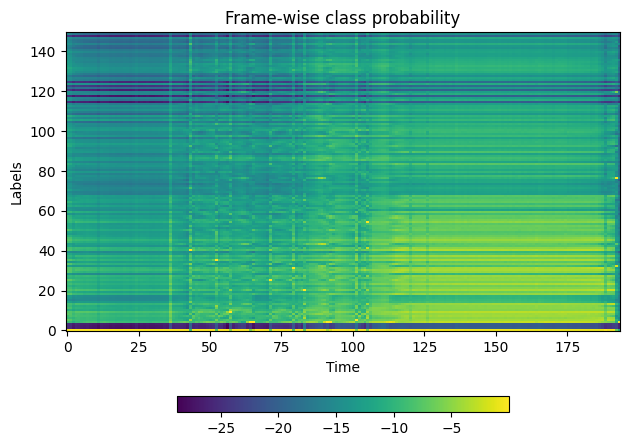

In [ ]:
# print(token.string(predicted_ids))

symbols = token.symbols
print(symbols)

import matplotlib.pyplot as plt

def plot(emission):
    fig, ax = plt.subplots()
    emission_cpu = emission.cpu().detach()  # Detach the tensor from its computation graph

    # Plot the emission matrix directly
    img = ax.imshow(emission_cpu.T, aspect='auto', origin='lower', interpolation='none')

    ax.set_title("Frame-wise class probability")
    ax.set_xlabel("Time")
    ax.set_ylabel("Labels")
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()
    plt.show()

# Assuming emission is already defined and has shape [seq_length, num_classes]
plot(emission)

In [ ]:
import torch

# We enclose the transcript with space tokens, which represent SOS and EOS.
if "hindi1" in sound_path:
  transcript = "|कसा|आहे|तू|"
if "hindi2" in sound_path:
  transcript = "|मी|पियुष|आहे|"

# if 'marathi_mother' in sound_path:
# transcript = "|मराठी|माझी|भाषा|आहे|"
# transcript = "|माझं|नाव|पियुष|आहे|"
print(transcript)

#ye hamesha nahi likha hai

#write a code to automatically write the transcript(use a loop)
labels = list(set(transcript))  # Get unique characters from the transcript
print(labels)
labels.sort()  # Optional: sort the labels
print(labels)

dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(tokens)
print(transcript)
print(list(zip(transcript, tokens)))


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    trellis = torch.zeros((num_frame, num_tokens))

    # Ensure blank_id is a scalar
    if torch.is_tensor(blank_id):
        blank_id = blank_id.item()

    cumsum = torch.cumsum(emission[1:,blank_id],dim=0)
    trellis[1:,0] = cumsum
    # trellis[1:, 0] = torch.cumsum(emission[1:, blank_id], 0).unsqueeze(1)
    # print(torch.cumsum(emission[1:, blank_id], 0).shape)
    trellis[0, 1:] = -float("inf")
    trellis[-num_tokens + 1 :, 0] = float("inf")
    for t in range(num_frame - 1):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens[1:]],
        )
    return trellis


trellis = get_trellis(emission, tokens)

print(trellis)
print(emission)
#150 kya hai  yaha??
#in depth understanding of trellis and emmissiom

print(len(tokens))
print(labels)
print(emission.shape)
print(trellis.shape)
print(type(emission))
print(type(trellis))

|कसा|आहे|तू|
['त', 'ू', 'ह', 'स', 'आ', 'े', 'ा', 'क', '|']
['|', 'आ', 'क', 'त', 'स', 'ह', 'ा', 'ू', 'े']
[0, 2, 4, 6, 0, 1, 5, 8, 0, 3, 7, 0]
|कसा|आहे|तू|
[('|', 0), ('क', 2), ('स', 4), ('ा', 6), ('|', 0), ('आ', 1), ('ह', 5), ('े', 8), ('|', 0), ('त', 3), ('ू', 7), ('|', 0)]
tensor([[ 0.0000e+00,        -inf,        -inf,  ...,        -inf,
                -inf,        -inf],
        [-8.7108e-03, -2.5265e+01,        -inf,  ...,        -inf,
                -inf,        -inf],
        [-1.1164e-02, -2.5273e+01, -3.4258e+01,  ...,        -inf,
                -inf,        -inf],
        ...,
        [        inf,         inf,         inf,  ..., -1.5768e+02,
         -1.6097e+02, -1.6097e+02],
        [        inf,         inf,         inf,  ...,         inf,
         -1.6139e+02, -1.6139e+02],
        [        inf,         inf,         inf,  ...,         inf,
                 inf, -1.6775e+02]])
tensor([[-1.1157e-02, -2.5361e+01, -2.5265e+01,  ..., -2.4127e+01,
         -1.5192e+01, -2.

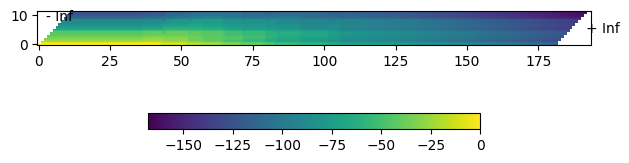

In [ ]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(trellis.T, origin="lower")
    ax.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
    ax.annotate("+ Inf", (trellis.size(0) - trellis.size(1) / 5, trellis.size(1) / 3))
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

In [ ]:
from dataclasses import dataclass

@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    t, j = trellis.size(0) - 1, trellis.size(1) - 1

    path = [Point(j, t, emission[t, blank_id].exp().item())]
    while j > 0:
        # Should not happen but just in case
        assert t > 0

        # 1. Figure out if the current position was stay or change
        # Frame-wise score of stay vs change
        p_stay = emission[t - 1, blank_id]
        p_change = emission[t - 1, tokens[j]]

        # Context-aware score for stay vs change
        stayed = trellis[t - 1, j] + p_stay
        changed = trellis[t - 1, j - 1] + p_change

        # Update position
        t -= 1
        if changed > stayed:
            j -= 1

        # Store the path with frame-wise probability.
        prob = (p_change if changed > stayed else p_stay).exp().item()
        path.append(Point(j, t, prob))

    # Now j == 0, which means, it reached the SoS.
    # Fill up the rest for the sake of visualization
    while t > 0:
        prob = emission[t - 1, blank_id].exp().item()
        path.append(Point(j, t - 1, prob))
        t -= 1

    return path[::-1]


path = backtrack(trellis, emission, tokens)
for p in path:
    print(p)

  #score kya hai yaha..

Point(token_index=0, time_index=0, score=0.9999246597290039)
Point(token_index=0, time_index=1, score=0.9999463558197021)
Point(token_index=0, time_index=2, score=0.999951958656311)
Point(token_index=0, time_index=3, score=0.9999547004699707)
Point(token_index=0, time_index=4, score=0.999953031539917)
Point(token_index=0, time_index=5, score=0.9999524354934692)
Point(token_index=0, time_index=6, score=0.9999542236328125)
Point(token_index=0, time_index=7, score=0.9999525547027588)
Point(token_index=0, time_index=8, score=0.9999523162841797)
Point(token_index=0, time_index=9, score=0.9999475479125977)
Point(token_index=0, time_index=10, score=0.9999502897262573)
Point(token_index=0, time_index=11, score=0.9999459981918335)
Point(token_index=0, time_index=12, score=0.9999499320983887)
Point(token_index=0, time_index=13, score=0.9999502897262573)
Point(token_index=0, time_index=14, score=0.9999351501464844)
Point(token_index=0, time_index=15, score=0.9999384880065918)
Point(token_index=0,

In [ ]:
import os
from dataclasses import dataclass
from pydub import AudioSegment
from IPython.display import Audio, display
import IPython

@dataclass
class Point:
    token_index: int
    time_index: int
    score: float

def backtrack(trellis, emission, tokens, blank_id=0):
    t, j = trellis.size(0) - 1, trellis.size(1) - 1

    path = [Point(j, t, emission[t, blank_id].exp().item())]
    while j > 0:
        # Should not happen but just in case
        assert t > 0

        # 1. Figure out if the current position was stay or change
        # Frame-wise score of stay vs change
        p_stay = emission[t - 1, blank_id]
        p_change = emission[t - 1, tokens[j]]

        # Context-aware score for stay vs change
        stayed = trellis[t - 1, j] + p_stay
        changed = trellis[t - 1, j - 1] + p_change

        # Update position
        t -= 1
        if changed > stayed:
            j -= 1

        # Store the path with frame-wise probability.
        prob = (p_change if changed > stayed else p_stay).exp().item()
        path.append(Point(j, t, prob))

    # Now j == 0, which means, it reached the SoS.
    # Fill up the rest for the sake of visualization
    while t > 0:
        prob = emission[t - 1, blank_id].exp().item()
        path.append(Point(j, t - 1, prob))
        t -= 1

    return path[::-1]

path = backtrack(trellis, emission, tokens)
for p in path:
  print(p)

@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def _repr_(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start

def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments

def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words

labels = list(set(transcript))  # Get unique characters from the transcript
labels.sort()  # Optional: sort the labels

dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))

# Assuming 'emission' is defined and properly initialized
trellis = get_trellis(emission, tokens)


segments = merge_repeats(path)
for seg in segments:
  print(seg)

word_segments = merge_words(segments)
for word in word_segments:
    print(word)

Point(token_index=0, time_index=0, score=0.9889051914215088)
Point(token_index=0, time_index=1, score=0.9913269877433777)
Point(token_index=0, time_index=2, score=0.9975500702857971)
Point(token_index=0, time_index=3, score=0.9958886504173279)
Point(token_index=0, time_index=4, score=0.9963440299034119)
Point(token_index=0, time_index=5, score=0.9970659613609314)
Point(token_index=0, time_index=6, score=0.9974408149719238)
Point(token_index=0, time_index=7, score=0.996921181678772)
Point(token_index=0, time_index=8, score=0.9973961114883423)
Point(token_index=0, time_index=9, score=0.997605562210083)
Point(token_index=0, time_index=10, score=0.9976089000701904)
Point(token_index=0, time_index=11, score=0.9989898800849915)
Point(token_index=0, time_index=12, score=0.9976648092269897)
Point(token_index=0, time_index=13, score=0.9978281855583191)
Point(token_index=0, time_index=14, score=0.9981903433799744)
Point(token_index=0, time_index=15, score=0.9985093474388123)
Point(token_index=0,

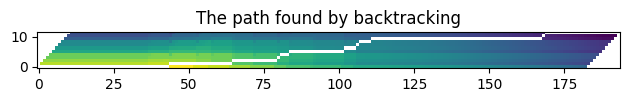

In [ ]:
def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path.T, origin="lower")
    plt.title("The path found by backtracking")
    plt.tight_layout()


plot_trellis_with_path(trellis, path)
#not cummulative..we re just proceeding to the next label

<ipython-input-14-bec29a247475>:38: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  fig.tight_layout()
<ipython-input-14-bec29a247475>:38: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.tight_layout()
<ipython-input-14-bec29a247475>:38: UserWarning: Glyph 2360 (\N{DEVANAGARI LETTER SA}) missing from current font.
  fig.tight_layout()
<ipython-input-14-bec29a247475>:38: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from current font.
  fig.tight_layout()
<ipython-input-14-bec29a247475>:38: UserWarning: Glyph 2310 (\N{DEVANAGARI LETTER AA}) missing from current font.
  fig.tight_layout()
<ipython-input-14-bec29a247475>:38: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from current font.
  fig.tight_layout()
<ipython-input-14-bec29a247475>:38: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from current font.
  fig.tight_layout()
<ipython-input-14-bec29a247475>:38: UserWarning: Glyph

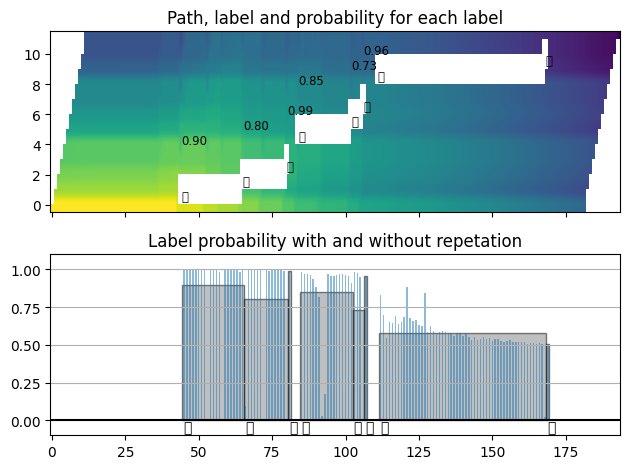

In [ ]:
def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07))
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.grid(True, axis="y")
    ax2.set_ylim(-0.1, 1.1)
    fig.tight_layout()


plot_trellis_with_segments(trellis, segments, transcript)

In [ ]:
# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
print(type(word_segments))
print(len(word_segments))
for word in word_segments:
    print(word)

<class 'list'>
3
Segment(label='कसा', start=44, end=81, score=0.8623683077709535)
Segment(label='आहे', start=84, end=107, score=0.8353424817753915)
Segment(label='तू', start=111, end=169, score=0.5760498444774541)


<ipython-input-16-f67bb74b2554>:41: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  fig.tight_layout()
<ipython-input-16-f67bb74b2554>:41: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.tight_layout()
<ipython-input-16-f67bb74b2554>:41: UserWarning: Glyph 2360 (\N{DEVANAGARI LETTER SA}) missing from current font.
  fig.tight_layout()
<ipython-input-16-f67bb74b2554>:41: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from current font.
  fig.tight_layout()
<ipython-input-16-f67bb74b2554>:41: UserWarning: Glyph 2310 (\N{DEVANAGARI LETTER AA}) missing from current font.
  fig.tight_layout()
<ipython-input-16-f67bb74b2554>:41: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from current font.
  fig.tight_layout()
<ipython-input-16-f67bb74b2554>:41: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from current font.
  fig.tight_layout()
<ipython-input-16-f67bb74b2554>:41: UserWarning: Glyph

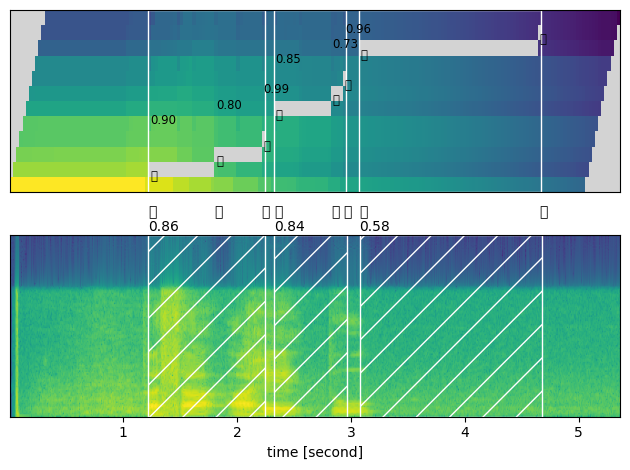

In [ ]:
import librosa

# Load the audio file
waveform, sample_rate = librosa.load(audio_path)

def plot_alignments(trellis, segments, word_segments, waveform, sample_rate=16000):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1)

    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")
    ax1.set_facecolor("lightgray")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvspan(word.start - 0.5, word.end - 0.5, edgecolor="white", facecolor="none")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    # The original waveform
    ratio = len(waveform) / sample_rate / trellis.size(0)
    ax2.specgram(waveform, Fs=sample_rate)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, facecolor="none", edgecolor="white", hatch="/")
        ax2.annotate(f"{word.score:.2f}", (x0, sample_rate * 0.51), annotation_clip=False)

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(seg.label, (seg.start * ratio, sample_rate * 0.55), annotation_clip=False)
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    fig.tight_layout()

    #karu me bohot jaldi boldiya..isliye 'r' ka confidence score kam aaya
plot_alignments(trellis, segments, word_segments, waveform)

In [ ]:
sample_rate = 16000
def display_segment(i):
    ratio = len(waveform) / trellis.size(0)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    print(f"{word.label} ({word.score:.2f}): {x0 / sample_rate:.3f} - {x1 / sample_rate:.3f} sec")
    segment = waveform[x0:x1]
    return IPython.display.Audio(segment, rate=sample_rate)

In [ ]:
import IPython
# Generate the audio for each segment
print(transcript)
IPython.display.Audio(sound_path)

|कसा|आहे|तू|


In [ ]:
display_segment(0)

कसा (0.86): 1.219 - 2.244 sec


In [ ]:
display_segment(1)

आहे (0.84): 2.327 - 2.964 sec


In [ ]:
display_segment(2)

तू (0.58): 3.075 - 4.682 sec


In [ ]:
display_segment(3)

आहे (0.82): 3.214 - 3.518 sec


In [ ]:
display_segment(4)

कर (0.74): 2.847 - 2.930 sec


In [ ]:
display_segment(5)

चांगल्े (0.65): 2.248 - 3.330 sec


In [ ]:
display_segment(6)

असतात (0.59): 3.469 - 3.802 sec
